
Forecasting Steam Cost


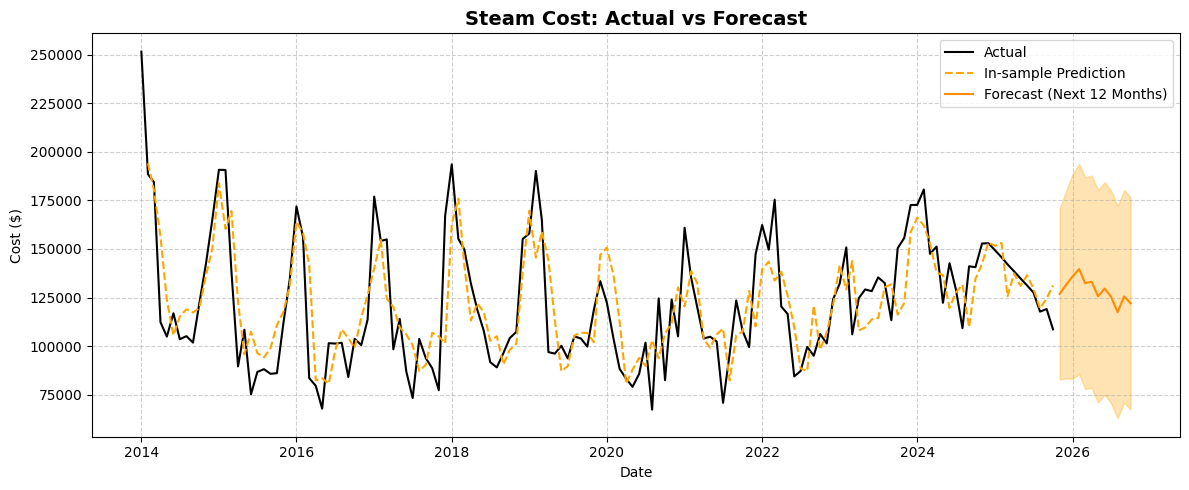


Forecasting Electric Cost


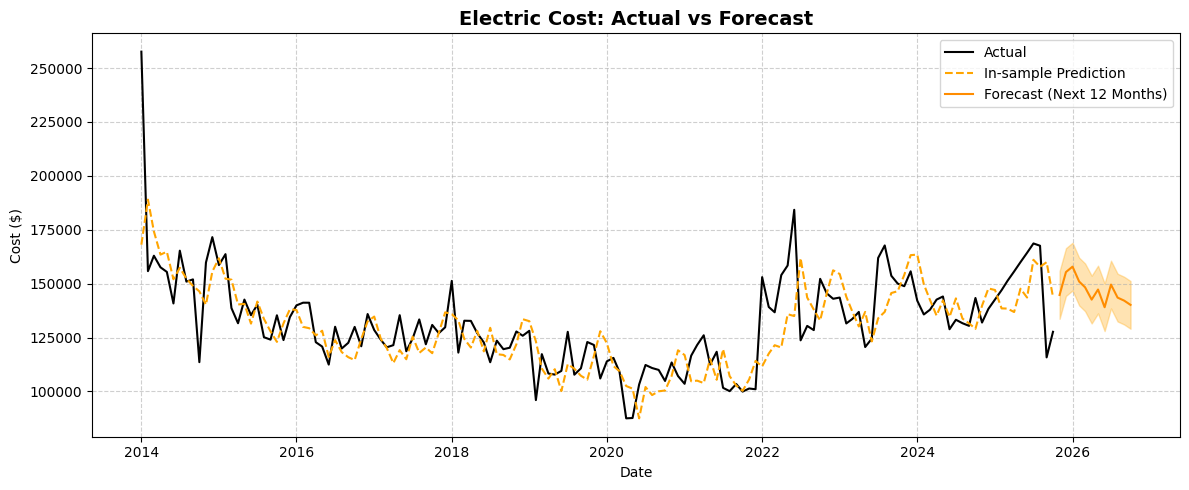


Forecasting Chilled Water Cost


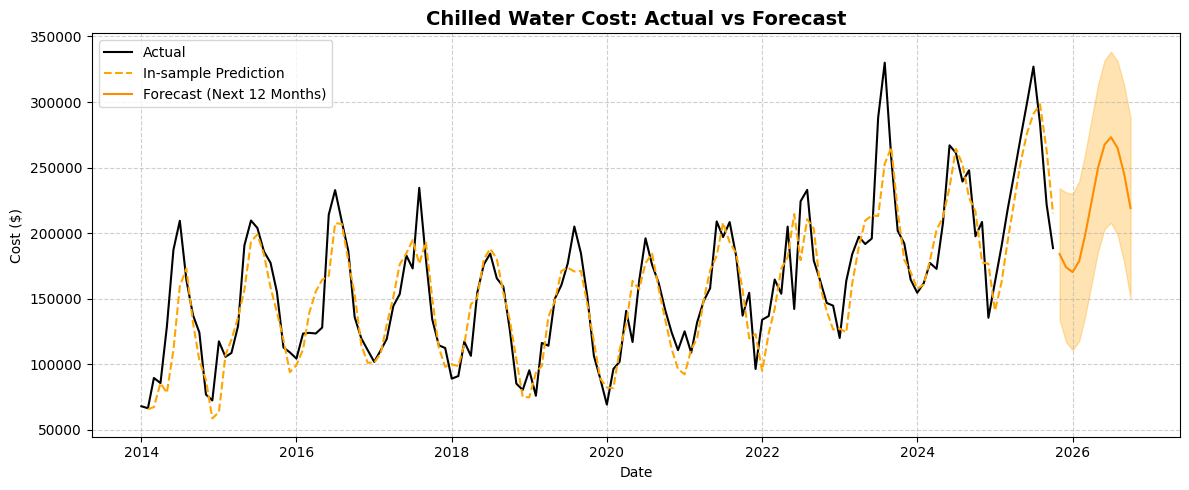


Forecasting Solar Cost


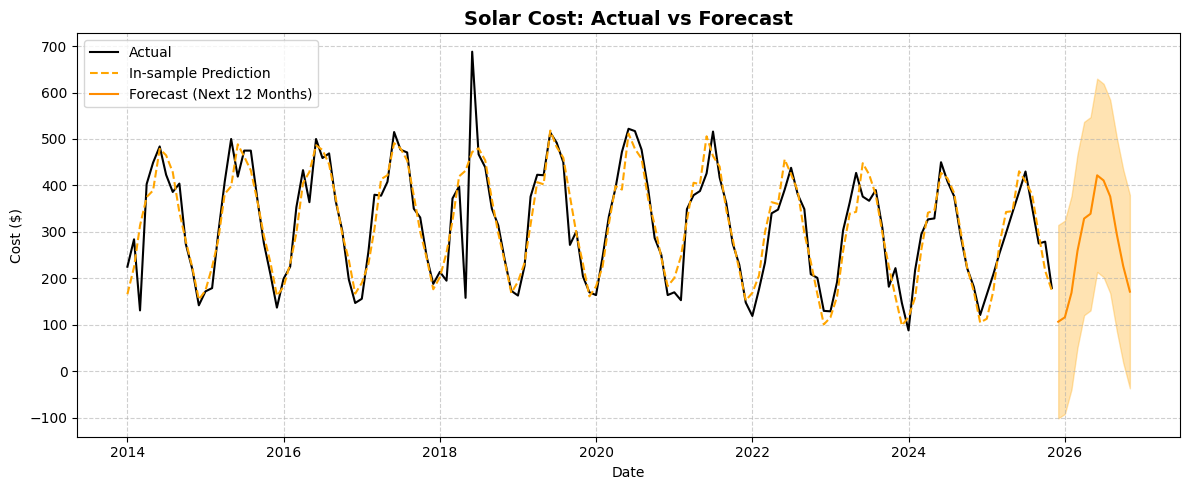


Forecasting Natural Gas Cost


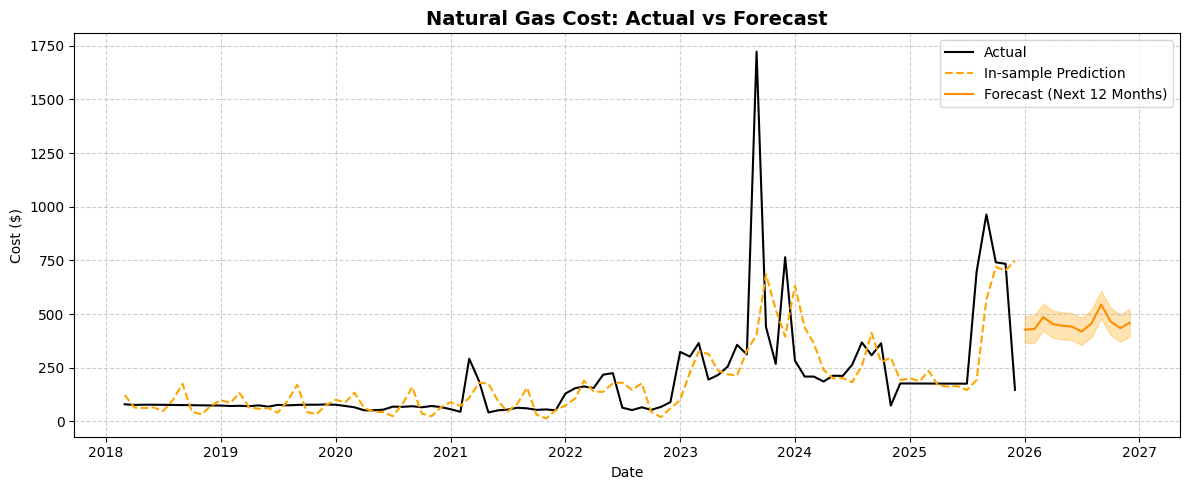

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pandas.tseries.offsets import DateOffset
import warnings

warnings.filterwarnings("ignore")

# Load and clean data
file_path = "/Users/ecebaltacioglu/my_project/venv_ece/sortedenergy.xlsx"
df = pd.read_excel(file_path, sheet_name='in')
df.columns = df.columns.str.strip()

# Format date
df['formatted date'] = pd.to_datetime(df['formatted date'])
df.set_index('formatted date', inplace=True)
df = df.sort_index()

# Define cost columns to forecast
cost_columns = ['Steam Cost', 'Electric Cost', 'Chilled Water Cost', 'Solar Cost', 'Natural Gas Cost']

for cost_column in cost_columns:
    print(f"\nForecasting {cost_column}")
    
    try:
        # Prepare the time series
        series = pd.to_numeric(df[cost_column], errors='coerce')
        series = series[series > 0].dropna()
        series = series.asfreq('MS').interpolate()

        if len(series) < 24:
            print(f"Not enough data for {cost_column}. Skipping.")
            continue

        # Define forecast placeholder
        forecast_index = [series.index[-1] + DateOffset(months=i) for i in range(1, 13)]

        # 🔸 Use ETS for Solar, Electric, and Natural Gas (with outlier handling)
        if cost_column == 'Solar Cost':
            model = ExponentialSmoothing(series, trend='add', seasonal='add', seasonal_periods=12)
            model_fit = model.fit()
            forecast = model_fit.forecast(12)
            lower_bound = forecast - 1.96 * np.std(forecast)
            upper_bound = forecast + 1.96 * np.std(forecast)
            fitted = model_fit.fittedvalues

        elif cost_column == 'Electric Cost':
            model = ExponentialSmoothing(series, trend='add', seasonal='add', seasonal_periods=12)
            model_fit = model.fit()
            forecast = model_fit.forecast(12)
            lower_bound = forecast - 1.96 * np.std(forecast)
            upper_bound = forecast + 1.96 * np.std(forecast)
            fitted = model_fit.fittedvalues

        elif cost_column == 'Natural Gas Cost':
            # Cap outliers above 99th percentile
            cap = series.quantile(0.99)
            capped_series = series.copy()
            capped_series[capped_series > cap] = cap

            model = ExponentialSmoothing(capped_series, trend='add', seasonal='add', seasonal_periods=12)
            model_fit = model.fit()
            forecast = model_fit.forecast(12)
            lower_bound = forecast - 1.96 * np.std(forecast)
            upper_bound = forecast + 1.96 * np.std(forecast)
            fitted = model_fit.fittedvalues

        # 🔹 Use ARIMA for other cost types
        else:
            stepwise_model = auto_arima(series, seasonal=True, m=12)
            model = ARIMA(series, order=stepwise_model.order, seasonal_order=stepwise_model.seasonal_order)
            model_fit = model.fit()
            forecast_result = model_fit.get_forecast(steps=12)
            forecast_df = forecast_result.summary_frame()
            forecast_df.index = forecast_index
            forecast = forecast_df['mean']
            lower_bound = forecast_df['mean_ci_lower']
            upper_bound = forecast_df['mean_ci_upper']
            fitted = model_fit.predict(start=series.index[1], end=series.index[-1], typ='levels')

        # Plot
        plt.figure(figsize=(12, 5))
        plt.plot(series, label='Actual', color='black')
        plt.plot(fitted, label='In-sample Prediction', linestyle='--', color='orange')
        plt.plot(forecast_index, forecast, label='Forecast (Next 12 Months)', color='darkorange')
        plt.fill_between(forecast_index, lower_bound, upper_bound, color='orange', alpha=0.3)

        plt.title(f"{cost_column}: Actual vs Forecast", fontsize=14, weight='bold')
        plt.xlabel("Date")
        plt.ylabel("Cost ($)")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error forecasting {cost_column}: {e}")



In [24]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load your data
file_path = "/Users/ecebaltacioglu/my_project/venv_ece/sortedenergy.xlsx"
df = pd.read_excel(file_path, sheet_name='in')
df.columns = df.columns.str.strip()
df['formatted date'] = pd.to_datetime(df['formatted date'])
df.set_index('formatted date', inplace=True)
df = df.sort_index()

cost_columns = ['Steam Cost', 'Electric Cost', 'Chilled Water Cost', 'Solar Cost', 'Natural Gas Cost']
metrics = []

for cost_column in cost_columns:
    print(f"\nForecasting {cost_column}")
    
    try:
        # Refresh series for each column
        series = pd.to_numeric(df[cost_column], errors='coerce')
        series = series[series > 0].dropna().asfreq('MS').interpolate()

        # Fit a model (ETS for all in this version)
        model = ExponentialSmoothing(series, trend='add', seasonal='add', seasonal_periods=12)
        model_fit = model.fit()
        fitted = model_fit.fittedvalues

        # Align actuals and predictions
        aligned_true, aligned_pred = series.align(fitted, join='inner')
        rmse = np.sqrt(mean_squared_error(aligned_true, aligned_pred))
        mae = mean_absolute_error(aligned_true, aligned_pred)
        
        metrics.append((cost_column, rmse, mae))
        print(f"Length of fitted for {cost_column}: {len(fitted)}")

    except Exception as e:
        print(f"⚠️  Skipping {cost_column} due to error: {e}")
        continue

# Print results
results_df = pd.DataFrame(metrics, columns=["Cost Category", "RMSE", "MAE"])
print("\n Forecast Accuracy Summary:")
print(results_df.to_string(index=False))




Forecasting Steam Cost
Length of fitted for Steam Cost: 142

Forecasting Electric Cost
Length of fitted for Electric Cost: 142

Forecasting Chilled Water Cost
Length of fitted for Chilled Water Cost: 142

Forecasting Solar Cost
Length of fitted for Solar Cost: 143

Forecasting Natural Gas Cost
Length of fitted for Natural Gas Cost: 94

 Forecast Accuracy Summary:
     Cost Category         RMSE          MAE
        Steam Cost 20487.804007 16380.973828
     Electric Cost 15876.416378 11202.022803
Chilled Water Cost 21963.653000 16993.985421
        Solar Cost    48.976701    32.857928
  Natural Gas Cost   199.104792   109.075791


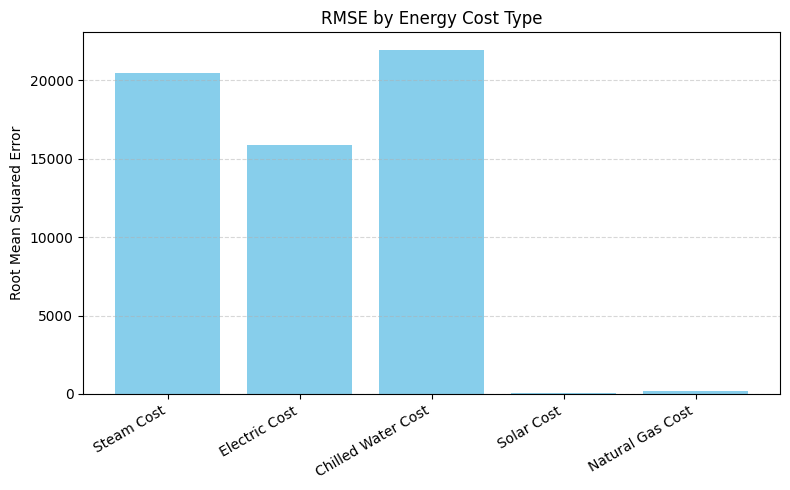

In [25]:
# Bar chart for RMSE
plt.figure(figsize=(8, 5))
plt.bar(results_df["Cost Category"], results_df["RMSE"], color='skyblue')
plt.title("RMSE by Energy Cost Type")
plt.ylabel("Root Mean Squared Error")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


Steam Cost


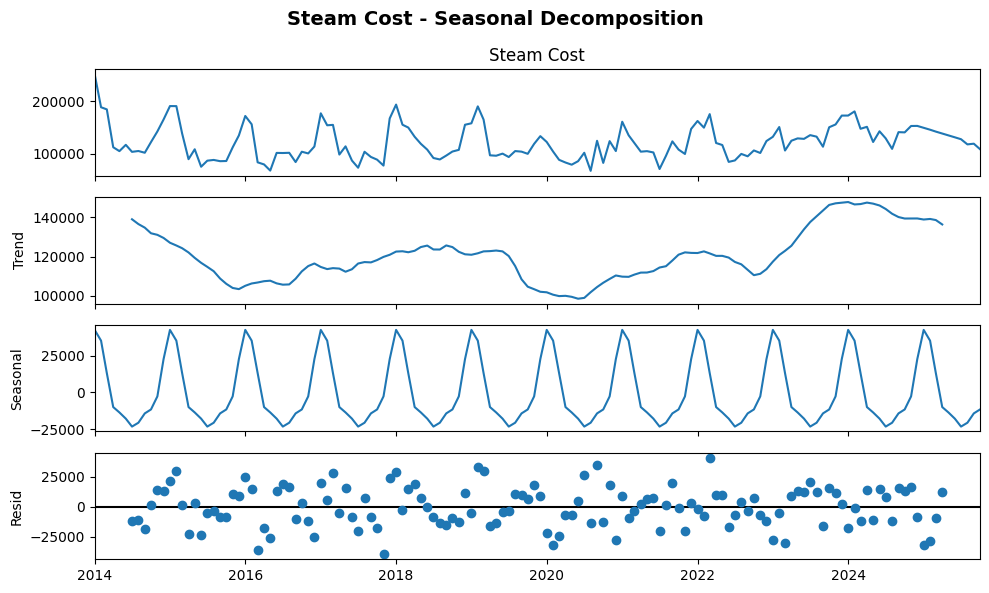


Electric Cost


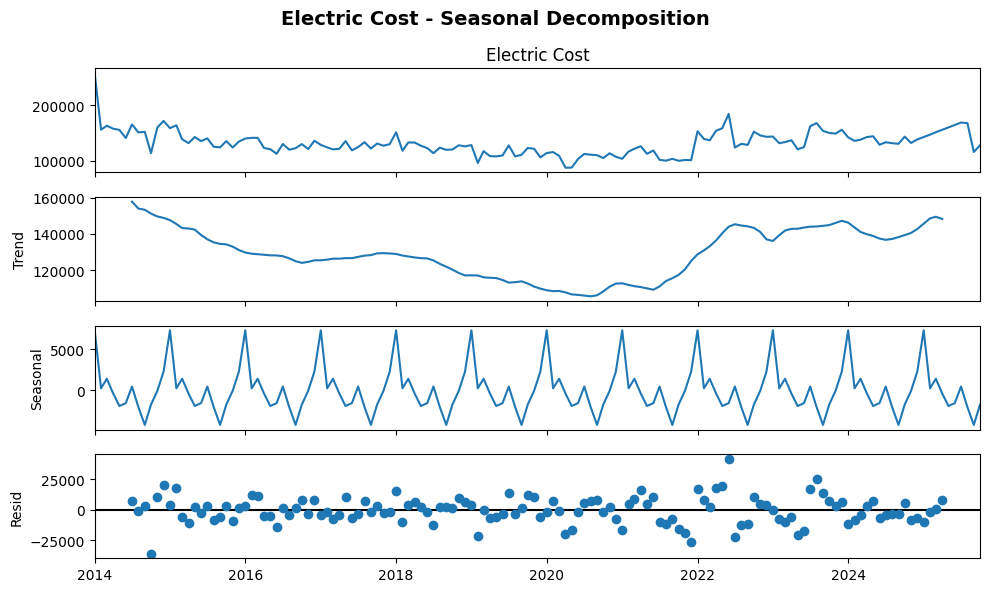


Chilled Water Cost


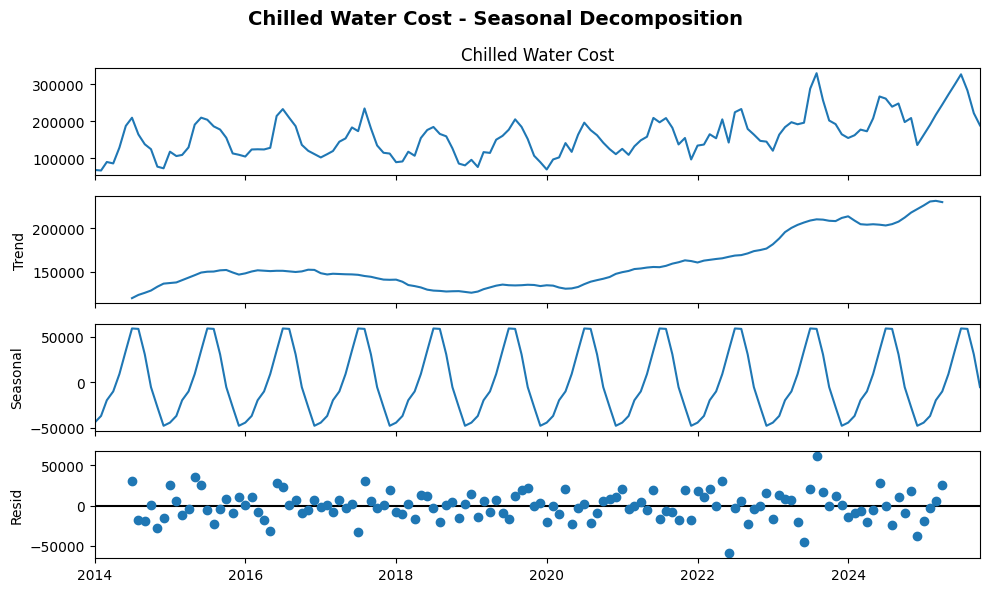


Solar Cost


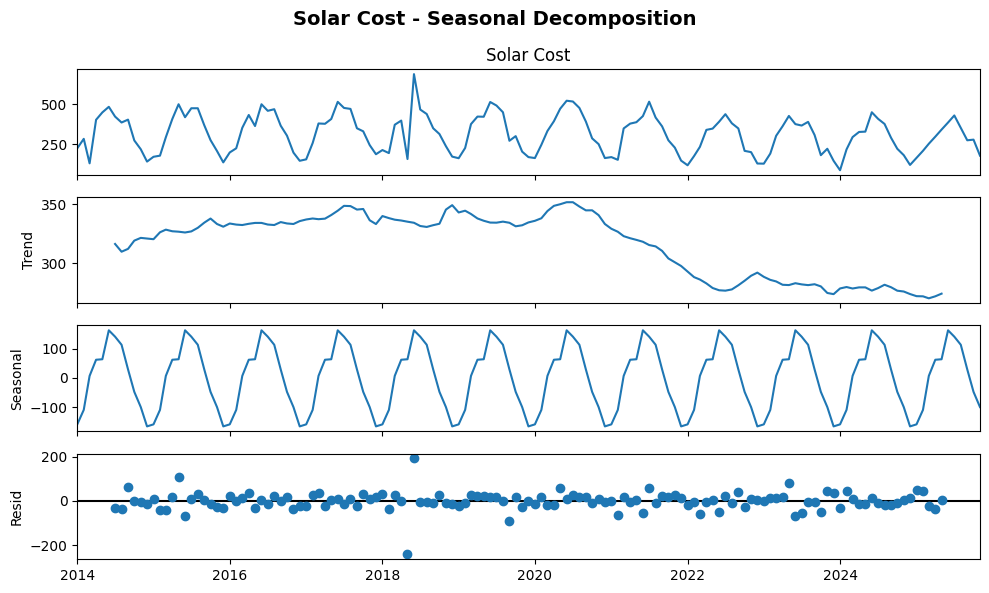


Natural Gas Cost


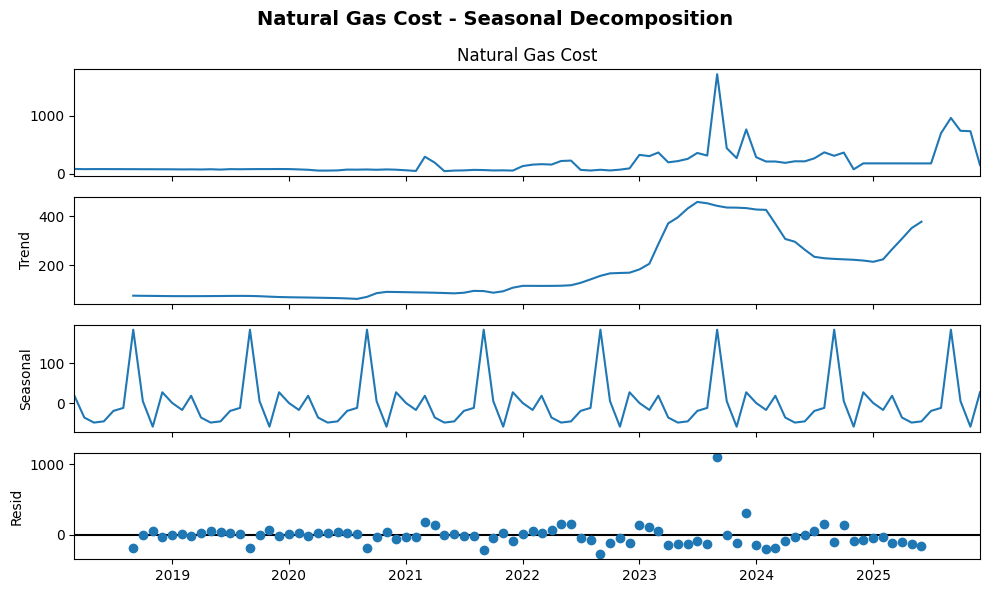

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

for cost_column in cost_columns:
    try:
        print(f"\n{cost_column}")
        
        series = pd.to_numeric(df[cost_column], errors='coerce')
        series = series[series > 0].dropna().asfreq('MS').interpolate()

        # Perform decomposition
        decomp = seasonal_decompose(series, model='additive', period=12)

        # Plot result
        fig = decomp.plot()
        fig.suptitle(f"{cost_column} - Seasonal Decomposition", fontsize=14, weight='bold')
        fig.set_size_inches(10, 6)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f" Skipping {cost_column} due to error: {e}")


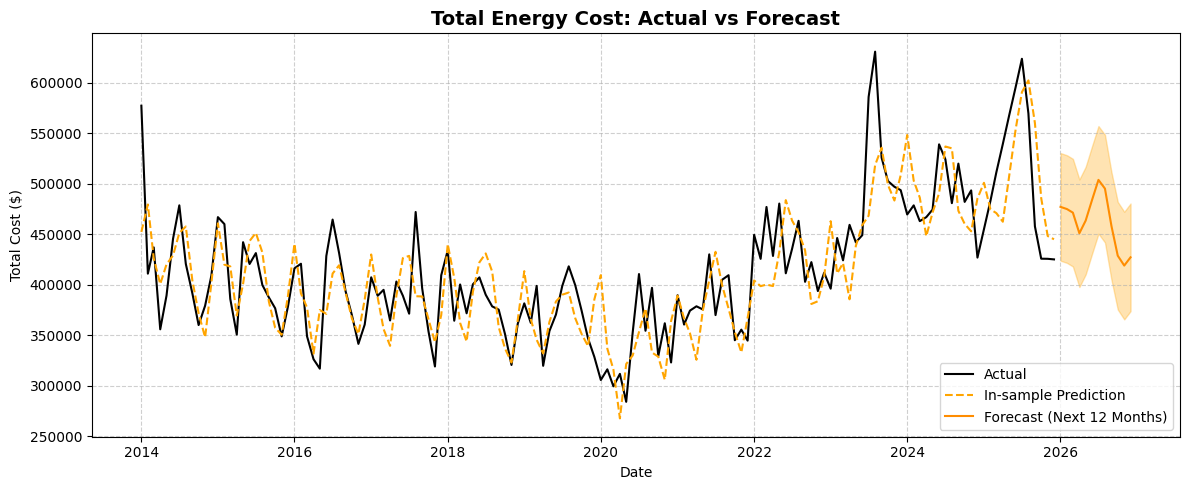

In [33]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pandas.tseries.offsets import DateOffset

# Preprocess cost columns
df_cleaned = df[cost_columns].apply(pd.to_numeric, errors='coerce')
df_cleaned = df_cleaned.asfreq('MS')
df_cleaned = df_cleaned.interpolate()
df_cleaned = df_cleaned.fillna(method='ffill').fillna(method='bfill')  # Fill remaining gaps

# Create total cost series
total_series = df_cleaned.sum(axis=1)

# Step 3: Fit model
model = ExponentialSmoothing(
    total_series,
    trend='add',
    seasonal='add',
    seasonal_periods=12
)
model_fit = model.fit()

# Forecast next 12 months
forecast = model_fit.forecast(12)
forecast_index = [total_series.index[-1] + DateOffset(months=i) for i in range(1, 13)]
forecast.index = forecast_index

# Plot
fitted = model_fit.fittedvalues

plt.figure(figsize=(12, 5))
plt.plot(total_series, label='Actual', color='black')
plt.plot(fitted, label='In-sample Prediction', linestyle='--', color='orange')
plt.plot(forecast, label='Forecast (Next 12 Months)', color='darkorange')
plt.fill_between(forecast.index,
                 forecast - 1.96 * forecast.std(),
                 forecast + 1.96 * forecast.std(),
                 color='orange', alpha=0.3)

plt.title("Total Energy Cost: Actual vs Forecast", fontsize=14, weight='bold')
plt.xlabel("Date")
plt.ylabel("Total Cost ($)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

